In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras import applications

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import glob
import os
print(os.listdir("/kaggle/input/dogs-vs-cats-redux-kernels-edition"))

['sample_submission.csv', 'train.zip', 'test.zip']


In [2]:
import zipfile


zip_files = ['test', 'train']
# Will unzip the files so that you can see them..
for zip_file in zip_files:
    with zipfile.ZipFile("/kaggle/input/dogs-vs-cats-redux-kernels-edition/{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test unzipped
train unzipped


In [3]:
print(os.listdir('/kaggle/input/dogs-vs-cats-redux-kernels-edition'))

['sample_submission.csv', 'train.zip', 'test.zip']


In [4]:
IMAGE_FOLDER_PATH="/kaggle/working/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

In [5]:
targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

In [6]:
dataset.head(10)


,image_path,target
0,/kaggle/working/train/dog.10346.jpg,dog
1,/kaggle/working/train/dog.3100.jpg,dog
2,/kaggle/working/train/cat.6123.jpg,cat
3,/kaggle/working/train/cat.8390.jpg,cat
4,/kaggle/working/train/dog.3961.jpg,dog
5,/kaggle/working/train/cat.8032.jpg,cat
6,/kaggle/working/train/cat.2126.jpg,cat
7,/kaggle/working/train/dog.3804.jpg,dog
8,/kaggle/working/train/dog.5763.jpg,dog
9,/kaggle/working/train/cat.9005.jpg,cat


In [7]:
target_counts=dataset['target'].value_counts()
print("Number of dogs in the dataset:{}".format(target_counts['dog']))
print("Number of cats in the dataset:{}".format(target_counts['cat']))

Number of dogs in the dataset:12500
Number of cats in the dataset:12500


In [8]:
def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target!=show and show!="both":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(WIDTH,HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

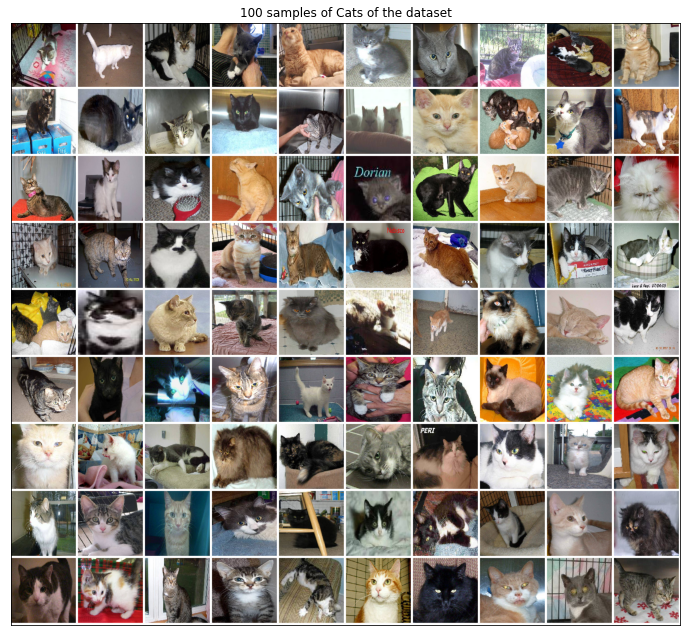

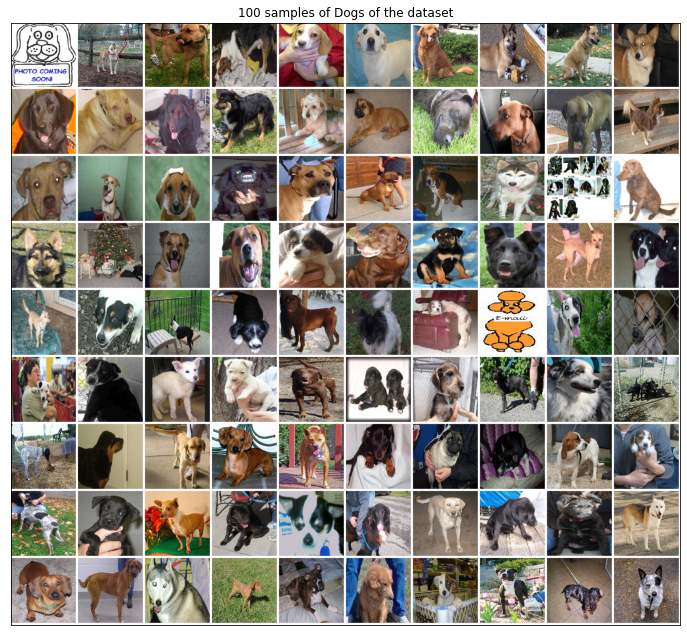

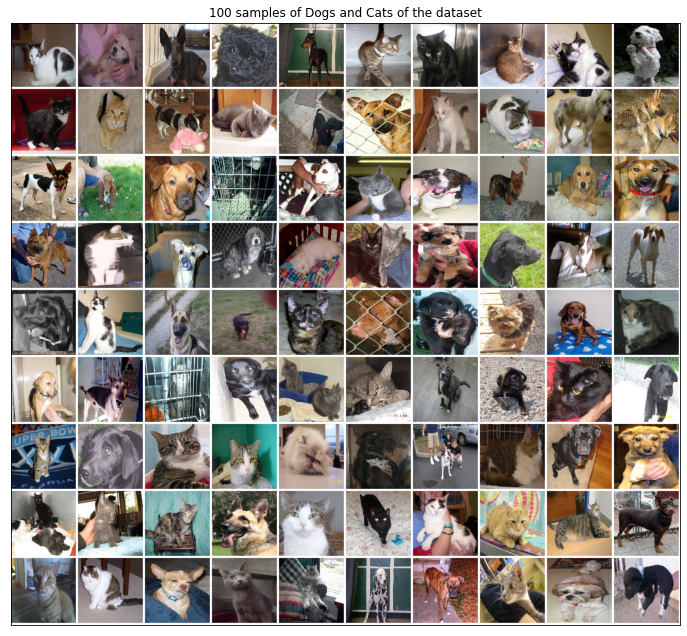

In [9]:
show_gallery(show="cat")
show_gallery(show="dog")
show_gallery(show="both")

In [10]:
def show_model_history(modelHistory, model_name):
    history=pd.DataFrame()
    history["Train Loss"]=modelHistory.history['loss']
    history["Validatin Loss"]=modelHistory.history['val_loss']
    history["Train Accuracy"]=modelHistory.history['accuracy']
    history["Validatin Accuracy"]=modelHistory.history['val_accuracy']
  
    history.plot(figsize=(12,8))
    plt.title(" Convulutional Model {} Train and Validation Loss and Accuracy History".format(model_name))
    plt.show()

In [11]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(weights = '/kaggle/input/vgg16-weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top = False, input_shape = input_shape)
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

2023-01-11 06:21:33.550648: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [12]:
model.compile(loss="binary_crossentropy", 
             optimizer= tf.optimizers.Adam(learning_rate=1e-4),
             metrics=["accuracy"])


In [13]:
dataset_train, dataset_test=train_test_split(dataset,
                                                 test_size=0.2,
                                                 random_state=42)

In [14]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
modelHistory=model.fit(train_datagenerator,
                                epochs=1,
                                validation_data=test_datagenerator,
                                validation_steps=dataset_test.shape[0]//150,
                                steps_per_epoch=dataset_train.shape[0]//150
                                )

2023-01-11 06:21:36.629889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


133/133 [==============================] - 2988s 22s/step - loss: 0.2570 - accuracy: 0.8878 - val_loss: 0.1536 - val_accuracy: 0.9362


In [17]:
model.save_weights("model.h5")


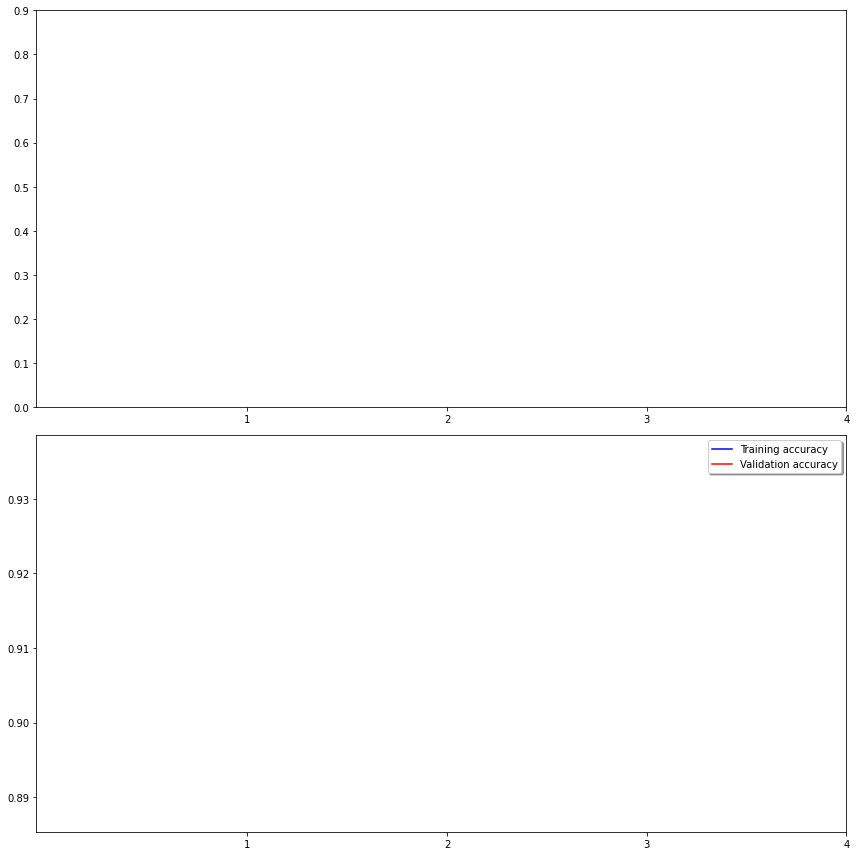

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(modelHistory.history['loss'], color='b', label="Training loss")
ax1.plot(modelHistory.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(modelHistory.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(modelHistory.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()